## The previous Graph was undirected

The directed graph was used to create these Peer-Peer links and Provider-Customer link

Link to Dataset: https://snap.stanford.edu/data/as-Caida.html

<>:7: SyntaxWarning: invalid escape sequence '\,'
<>:7: SyntaxWarning: invalid escape sequence '\,'
/var/folders/tq/11x_4qtd021fc63b_j873k5r0000gn/T/ipykernel_8215/1860390578.py:7: SyntaxWarning: invalid escape sequence '\,'
  df = pd.read_csv('Directed.csv', sep='\,',
/var/folders/tq/11x_4qtd021fc63b_j873k5r0000gn/T/ipykernel_8215/1860390578.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('Directed.csv', sep='\,',


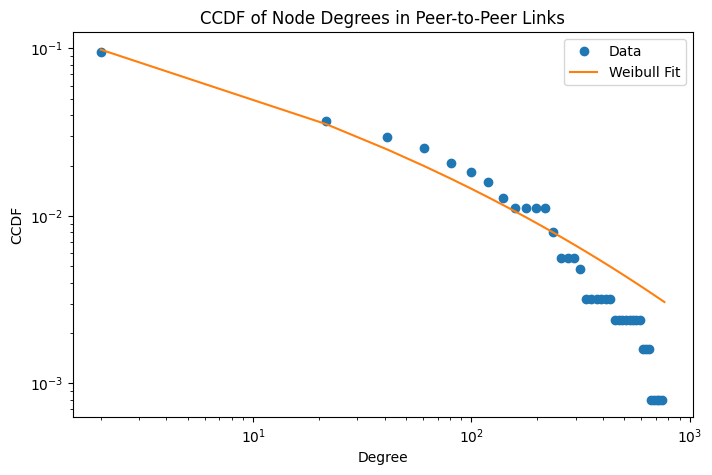

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from scipy.stats import linregress

df = pd.read_csv('Directed.csv', sep='\,',
                 names=['FromNodeId', 'ToNodeId', 'Relationship'])


from scipy.stats import weibull_min
from scipy.optimize import curve_fit

# Assuming you have a DataFrame 'df' with the dataset
peer_df = df[df['Relationship'] == 0]

# Create a graph and calculate degrees
G = nx.from_pandas_edgelist(peer_df, 'FromNodeId', 'ToNodeId', create_using=nx.DiGraph())
degrees = [G.degree(n) for n in G.nodes()]

# Calculate CCDF
values, base = np.histogram(degrees, bins=40, density=True)
cumulative = np.cumsum(values)
ccdf = 1 - cumulative / max(cumulative)

# Fit to Weibull distribution
def weibull_fit(x, c, scale):
    return 1 - weibull_min.cdf(x, c, scale=scale)

params, _ = curve_fit(weibull_fit, base[:-1], ccdf, p0=[1, np.mean(degrees)])

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(base[:-1], ccdf, 'o', label='Data')
plt.plot(base[:-1], weibull_fit(base[:-1], *params), '-', label='Weibull Fit')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Degree')
plt.ylabel('CCDF')
plt.title('CCDF of Node Degrees in Peer-to-Peer Links')
plt.legend()
plt.show()


/var/folders/tq/11x_4qtd021fc63b_j873k5r0000gn/T/ipykernel_8215/4104015630.py:22: RuntimeWarning: divide by zero encountered in log
  log_ccdf = np.log(ccdf)


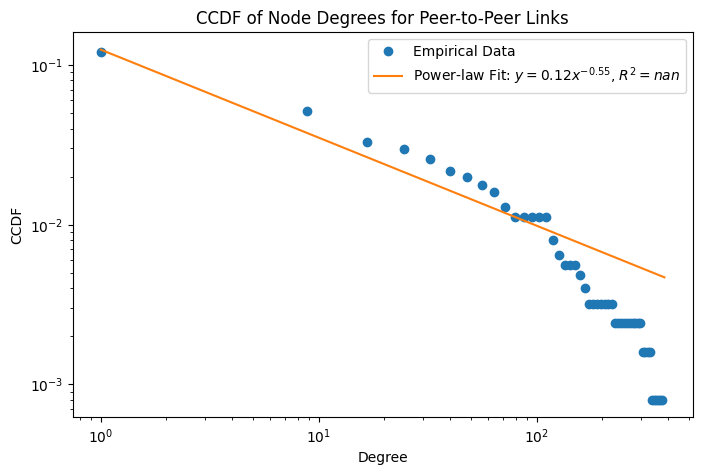

Power-law fit parameters: [0.5517951 0.124893 ]


In [15]:
# Filter for peer-to-peer relationships
peer_df = df[df['Relationship'] == 0]

# Create a graph from the peer-to-peer subset
G = nx.from_pandas_edgelist(peer_df, 'FromNodeId', 'ToNodeId', create_using=nx.Graph())

# Get the degree of each node
degrees = [G.degree(n) for n in G.nodes()]

# Calculate the CCDF
values, base = np.histogram(degrees, bins=50, density=True)
cumulative = np.cumsum(values)
ccdf = 1 - cumulative / cumulative[-1]

# Fit the CCDF to a power-law model
# Define the power-law function
def power_law(x, alpha, k):
    return k * np.power(x, -alpha)

# Perform the fit on the log-log data
log_base = np.log(base[:-1])
log_ccdf = np.log(ccdf)
params, _ = curve_fit(power_law, base[:-1], ccdf)

# Calculate the correlation coefficient
predicted = power_law(base[:-1], *params)
log_predicted = np.log(predicted)
r_value, _ = linregress(log_ccdf, log_predicted)[:2]

# Plot the CCDF and the power-law fit
plt.figure(figsize=(8, 5))
plt.loglog(base[:-1], ccdf, 'o', label='Empirical Data')
plt.loglog(base[:-1], predicted, '-', label=f'Power-law Fit: $y = {params[1]:.2f}x^{{-{params[0]:.2f}}}$, $R^2 = {r_value**2:.3f}$')
plt.xlabel('Degree')
plt.ylabel('CCDF')
plt.title('CCDF of Node Degrees for Peer-to-Peer Links')
plt.legend()
plt.show()

# Output the fit parameters and correlation coefficient
print('Power-law fit parameters:', params)

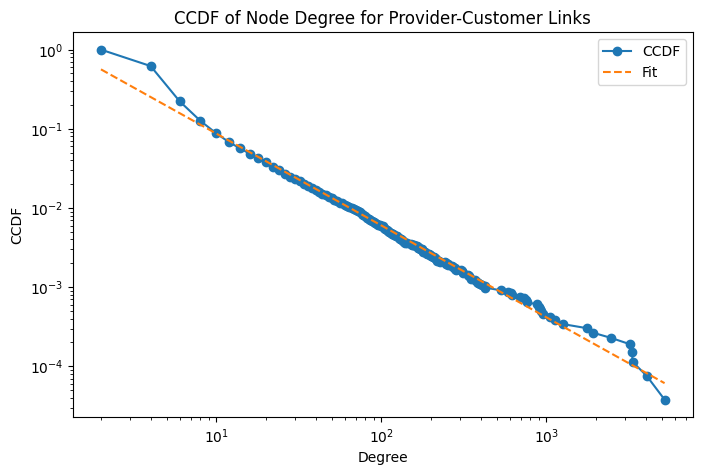

Correlation coefficient (R^2): 0.9913752950835807


In [4]:
# Filter for provider-customer relationships (Relationship == -1 or 1)
provider_customer_df = df[(df['Relationship'] == -1) | (df['Relationship'] == 1)]


G = nx.DiGraph()
for index, row in provider_customer_df.iterrows():
    G.add_edge(row['FromNodeId'], row['ToNodeId'])
    
# Calculate degrees
degrees = [G.degree(n) for n in G.nodes()]

# Compute CCDF
unique_degrees = np.unique(degrees)
histogram = [np.sum(degrees >= degree) for degree in unique_degrees]
ccdf = np.array(histogram) / len(degrees)

# Perform least squares fitting on log-log scale
log_degrees = np.log(unique_degrees)
log_ccdf = np.log(ccdf)
slope, intercept, r_value, p_value, std_err = linregress(log_degrees, log_ccdf)

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(unique_degrees, ccdf, marker='o', linestyle='-', label='CCDF')
plt.plot(unique_degrees, np.exp(intercept + slope * log_degrees), label='Fit', linestyle='--')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Degree')
plt.ylabel('CCDF')
plt.title('CCDF of Node Degree for Provider-Customer Links')
plt.legend()
plt.show()

print(f"Correlation coefficient (R^2): {r_value**2}")
